# This notebook provides the code for Figure 1

In [1]:
import numpy as np
import ot
import ot.plot
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from losses import swgg_opt
import torch
from torchdyn.datasets import generate_moons

### Sample distributions

In [447]:
def draw_circles(n, seed=0):

    np.random.seed(seed)
    noisy_circles, y = make_circles(n_samples=n*2, factor=0.5, noise=0.075, random_state=170)
    x = noisy_circles[np.argwhere(y==0),:].reshape(n, 2) + 1
    y = noisy_circles[np.argwhere(y==1),:].reshape(n, 2)  -1
    C = ot.dist(x,y)

    coord_circle_1 = 100
    coord_circle_2 = 100
    x_1d = (np.pi + np.arctan2((x[:,1] + coord_circle_2), (x[:,0] + coord_circle_1))) / (2*np.pi)
    y_1d = (np.pi + np.arctan2((y[:,1] + coord_circle_2), (y[:,0] + coord_circle_1))) / (2*np.pi)

    pos_x = x[np.argsort(x_1d)]
    pos_y = y[np.argsort(y_1d)]
    print("true Wass distance", np.mean(np.sum(np.abs(pos_x - pos_y)**2, axis = -1), axis = 0))
    print("true Wasserstein distance", ot.emd2([], [], C))
    print("'radom' OT distance", np.mean(np.sum(np.abs(x - y)**2, axis = -1), axis = 0))

    return torch.tensor(x), torch.tensor(y), x_1d, y_1d, ot.emd([], [], C), np.round(ot.emd2([], [], C), 2)

n = 50
seed = 0
offset = 5
x0, x1, x0_1d, x1_1d, plan, cost = draw_circles(n, seed)





true Wass distance 8.74504865264115
true Wasserstein distance 8.323015665641105
'radom' OT distance 9.34283995938105


### SWGG (projection on a line)

In [ ]:
n_iter=10000
epsilon_Stein=5e-1
n_samples_Stein=20
model_lin = torch.nn.Linear(in_features=2, out_features=1, bias = False, dtype=torch.double)
opt_model = torch.optim.Adam(model_lin.parameters(), lr=2)

swgg_opt(x0, x1, model_lin, opt_model, 
         n_iter=n_iter, epsilon_Stein=epsilon_Stein, n_samples_Stein=n_samples_Stein,
         log=False)


In [375]:
indices0 = torch.argsort(model_lin(x0).flatten())
indices1 = torch.argsort(model_lin(x1).flatten())
x0_plot_lin = x0[indices0]
x1_plot_lin = x1[indices1]
cost_lin = np.round(torch.mean(torch.sum(torch.abs(x0_plot_lin - x1_plot_lin)**2, axis = -1)).numpy(), 2)


### DSWP (projection on a circle)

In [376]:
class Circle(torch.nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.direction = torch.nn.Parameter(torch.randn(size=(1,in_features), dtype=torch.float64, requires_grad=True))
        
    def proj_circle(self, x):
        x = torch.atan2((x[:,1] - self.direction[0,1]), (x[:,0]-self.direction[0,0]))
        return x 
    
    def forward(self, x):
        x = self.proj_circle(x)
        return x

In [444]:
n_iter=20000
epsilon_Stein=5e0
n_samples_Stein = 20
model_circle = Circle(in_features=2)
opt_model_circle = torch.optim.SGD(model_circle.parameters(), lr=5, momentum=0.9)

In [ ]:

swgg_opt(x0, x1, model_circle, opt_model_circle, 
         n_iter=n_iter, epsilon_Stein=epsilon_Stein, n_samples_Stein=n_samples_Stein,
         log=True)
print(model_circle.direction)

swgg log loss=8.980
swgg log loss=8.822
swgg log loss=8.828
swgg log loss=8.796
swgg log loss=8.789
swgg log loss=8.779
swgg log loss=8.797
swgg log loss=8.796
swgg log loss=8.792
swgg log loss=8.791
swgg log loss=8.766
swgg log loss=8.790
swgg log loss=8.795
swgg log loss=8.797
swgg log loss=8.785
swgg log loss=8.792
swgg log loss=8.761
swgg log loss=8.782
swgg log loss=8.801
swgg log loss=8.779
swgg log loss=8.780
swgg log loss=8.783
swgg log loss=8.773
swgg log loss=8.754
swgg log loss=8.762
swgg log loss=8.788
swgg log loss=8.757
swgg log loss=8.775
swgg log loss=8.770
swgg log loss=8.777
swgg log loss=8.754
swgg log loss=8.774
swgg log loss=8.774
swgg log loss=8.770
swgg log loss=8.776
swgg log loss=8.786
swgg log loss=8.800
swgg log loss=8.777
swgg log loss=8.762
swgg log loss=8.754
swgg log loss=8.768
swgg log loss=8.762
swgg log loss=8.761
swgg log loss=8.750
swgg log loss=8.782
swgg log loss=8.797
swgg log loss=8.785
swgg log loss=8.773
swgg log loss=8.787
swgg log loss=8.776


In [383]:
indices0 = torch.argsort(model_circle(x0).flatten())
indices1 = torch.argsort(model_circle(x1).flatten())
x0_plot_circle = x0[indices0].detach().numpy()
x1_plot_circle = x1[indices1].detach().numpy()

cost_cir = np.round(np.mean(np.sum(np.abs(x0_plot_circle - x1_plot_circle)**2, axis = -1)), 2)



In [384]:
coef_circle = model_circle.state_dict()["direction"].data 
coef_circle = coef_circle.detach().numpy()[0]
print(coef_circle)

[-213.22279464 -162.62255751]


### SWGG (projection on NN)

In [ ]:
model_nn = torch.nn.Sequential(  # TODO
            torch.nn.Linear(in_features=2, out_features=16, dtype=torch.double),
            torch.nn.ReLU(),
            #torch.nn.Linear(in_features=256, out_features=128, dtype=torch.double),
            #torch.nn.SELU(),
            torch.nn.Linear(in_features=16, out_features=1, dtype=torch.double)
        )
n_iter = 10000
epsilon_Stein = 5e-1
n_samples_Stein = 20
model_circle = model_nn
opt_model_nn = torch.optim.SGD(model_nn.parameters(), lr=.5, momentum=0.9)
swgg_opt(x0, x1, model_nn, opt_model_nn, 
         n_iter=n_iter, epsilon_Stein=epsilon_Stein, n_samples_Stein=n_samples_Stein,
         log=True)


In [426]:
indices0 = torch.argsort(model_nn(x0).flatten())
indices1 = torch.argsort(model_nn(x1).flatten())
x0_plot_nn = x0[indices0].detach().numpy()
x1_plot_nn = x1[indices1].detach().numpy()

cost_nn = np.round(np.mean(np.sum(np.abs(x0_plot_nn - x1_plot_nn)**2, axis = -1)), 2)



## Overall plot

In [781]:
plt.figure(figsize=(15, 4))
plt.subplot(141)
plt.scatter(x0[:,0].detach().numpy(), x0[:,1].detach().numpy(), c= "C0", label='source', marker="+")
plt.scatter(x1[:,0].detach().numpy(), x1[:,1].detach().numpy(), c = 'C1', label='target')
ot.plot.plot2D_samples_mat(x0.detach().numpy(), x1.detach().numpy(), plan, linestyle="solid", alpha=.5,c="grey")
plt.xlim(-2, 2.5)
plt.ylim(-2, 2.5)
plt.xticks([])
plt.yticks([])
#plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)
plt.legend()
plt.title(f"Plan (exact), cost={cost}")

col1 = np.arange(1,x0_plot_lin.shape[0]+1)/x0_plot_lin.shape[0]

plt.subplot(142)
plt.scatter(x0_plot_lin[:, 0], x0_plot_lin[:, 1], c=col1, cmap="winter", marker="+")
plt.scatter(x1_plot_lin[:, 0], x1_plot_lin[:, 1], c=col1, cmap="winter")
plt.xlim(-2, 2.5)
plt.ylim(-2, 2.5)
plt.xticks([])
plt.yticks([])

plt.axline(torch.tensor([0,0]), model_lin.weight[0].detach(), color='k')

for x0i, x1i in zip(x0_plot_lin, x1_plot_lin):
    plt.plot([x0i[0], x1i[0]],
             [x0i[1], x1i[1]],
            linestyle="solid", alpha=.5,c="grey")
plt.title(f"SWGG, cost={cost_lin}")

plt.subplot(143)
col1 = np.arange(1,x0_plot_circle.shape[0]+1)/x0_plot_circle.shape[0]
plt.scatter(x0_plot_circle[:, 0], x0_plot_circle[:, 1], c=col1, cmap="winter", marker="+")
plt.scatter(x1_plot_circle[:, 0], x1_plot_circle[:, 1], c=col1, cmap="winter")
plt.xlim(-2, 2.5)
plt.ylim(-2, 2.5)
plt.xticks([])
plt.yticks([])


for x0i, x1i, col in zip(x0_plot_circle, x1_plot_circle, col1):
    plt.plot([x0i[0], x1i[0]],
             [x0i[1], x1i[1]],
            linestyle="solid", alpha=.5,c="grey")
plt.title(f"DSWP (circular), cost={cost_cir}")
#print("true Wass distance", np.mean(np.sum(np.abs(pos_x - pos_y)**2, axis = -1), axis = 0))


plt.subplot(144)

plt.scatter(x0_plot_nn[:, 0], x0_plot_nn[:, 1], c=col1, cmap="winter", marker="+")
plt.scatter(x1_plot_nn[:, 0], x1_plot_nn[:, 1], c=col1, cmap="winter")
plt.xlim(-2, 2.5)
plt.ylim(-2, 2.5)
plt.xticks([])
plt.yticks([])
for x0i, x1i, col in zip(x0_plot_nn, x1_plot_nn, col1):
    plt.plot([x0i[0], x1i[0]],
             [x0i[1], x1i[1]],
            linestyle="solid", alpha=.5,c="grey")
plt.title(f"DSWP (NN), cost={cost_nn}")

plt.show()

ValueError: 'c' argument has 50 elements, which is inconsistent with 'x' and 'y' with size 1024.

Error in callback <function _draw_all_if_interactive at 0x36a401750> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1500x400 with 4 Axes>

# now, with the OT-CFM illustration

In [2]:
%load_ext autoreload
%autoreload 2
#from cfm_utils import sample_8gaussians, sample_moons
import math

import random
random.seed(0)
torch.manual_seed(0)

In [3]:
def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1.5, 0),
        (-1.75, 0.5),
        (0, 1.5),
        (0, -1),
        (.75 / np.sqrt(2), 1. / np.sqrt(2)),
        (1.3 / np.sqrt(2), -1. / np.sqrt(2)),
        (-1.95 / np.sqrt(2), 2 / np.sqrt(2)),
        (-1 / np.sqrt(2), -0.25 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    #multi = torch.multinomial(torch.ones(8), n, replacement=True)
    multi = torch.zeros(n//8, dtype=torch.int8)
    for i in range(1,8):
        multi = torch.cat((multi, i*torch.ones(n//8, dtype=torch.int8)))
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()

def sample_moons(n):
    x0, y = generate_moons(n, noise=0.2)
    x0[torch.where(y==0)[0],1] += .3
    return x0 * 3 - 1

true Wasserstein distance 13.464012663112953
'radom' OT distance 60.840347


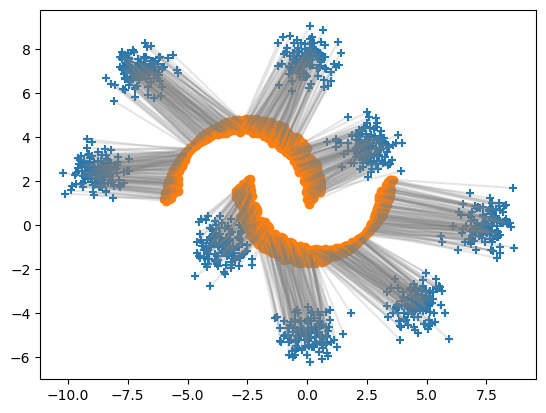

In [8]:
seed = 2025
np.random.seed(seed)
torch.manual_seed(seed)

x0 = sample_8gaussians(1024)#1024

#x0 *= 1.5
x1 = sample_moons(1024)
#x1[:,1] = x1[:,1] + 1
x1[:,0] -= 2
x1[:,1] *= 1.1
x1[:,1]+= 1

n_iter=2000
epsilon_Stein=5e-2
n_samples_Stein=20
roll_back=True

C = ot.dist(x0,x1)

cost = ot.emd2([], [], C.numpy())
plan = ot.emd([], [], C.numpy())
print("true Wasserstein distance", cost)
print("'radom' OT distance", np.mean(np.sum(np.abs(x0.numpy() - x1.numpy())**2, axis = -1), axis = 0))

plt.scatter(x0[:,0].detach().numpy(), x0[:,1].detach().numpy(), c= "C0", label='source', marker="+")
plt.scatter(x1[:,0].detach().numpy(), x1[:,1].detach().numpy(), c = 'C1', label='target')
ot.plot.plot2D_samples_mat(x0.detach().numpy(), x1.detach().numpy(), plan, linestyle="solid", alpha=.2,c="grey")


In [14]:
seed = 2025
np.random.seed(seed)
torch.manual_seed(seed)
n_iter=10000
epsilon_Stein=5e-1
n_samples_Stein=20
model_lin = torch.nn.Linear(in_features=2, out_features=1, bias = False, dtype=torch.float)
opt_model = torch.optim.Adam(model_lin.parameters(), lr=2)

swgg_opt(x0, x1, model_lin, opt_model, 
         n_iter=n_iter, epsilon_Stein=epsilon_Stein, n_samples_Stein=n_samples_Stein,
         log=False)

indices0 = torch.argsort(model_lin(x0).flatten())
indices1 = torch.argsort(model_lin(x1).flatten())
x0_plot_lin = x0[indices0].detach()
x1_plot_lin = x1[indices1].detach()
cost_lin = np.round(torch.mean(torch.sum(torch.abs(x0_plot_lin - x1_plot_lin)**2, axis = -1)).numpy(), 2)
print(cost_lin)

20.29


In [15]:
x0_plot_lin = x0[indices0].detach()
x1_plot_lin = x1[indices1].detach()
cost_lin = torch.mean(torch.sum(torch.abs(x0_plot_lin - x1_plot_lin)**2, axis = -1)).numpy()

In [21]:
seed = 2025
np.random.seed(seed)
torch.manual_seed(seed)
model_nn = torch.nn.Sequential( 
            torch.nn.Linear(in_features=2, out_features=64, dtype=torch.float),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=64, out_features=16, dtype=torch.float),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=1, dtype=torch.float)
        )
n_iter = 10000
epsilon_Stein = 1e-1
n_samples_Stein = 20
model_circle = model_nn
opt_model_nn = torch.optim.SGD(model_nn.parameters(), lr=.2)#, momentum=0.9)
swgg_opt(x0, x1, model_nn, opt_model_nn, 
         n_iter=n_iter, epsilon_Stein=epsilon_Stein, n_samples_Stein=n_samples_Stein,
         log=True)

swgg log loss=37.192
swgg log loss=23.989
swgg log loss=23.216
swgg log loss=21.629
swgg log loss=20.856
swgg log loss=20.364
swgg log loss=24.718
swgg log loss=18.539
swgg log loss=17.625
swgg log loss=17.377
swgg log loss=17.182
swgg log loss=17.133
swgg log loss=16.980
swgg log loss=16.714
swgg log loss=16.465
swgg log loss=16.168
swgg log loss=16.460
swgg log loss=16.236
swgg log loss=18.608
swgg log loss=16.153
swgg log loss=16.089
swgg log loss=16.329
swgg log loss=16.321
swgg log loss=15.789
swgg log loss=15.950
swgg log loss=16.234
swgg log loss=15.883
swgg log loss=15.942
swgg log loss=15.884
swgg log loss=15.847
swgg log loss=15.793
swgg log loss=15.934
swgg log loss=15.451
swgg log loss=15.525
swgg log loss=15.383
swgg log loss=15.429
swgg log loss=15.591
swgg log loss=15.437
swgg log loss=15.639
swgg log loss=15.438
swgg log loss=15.672
swgg log loss=15.601
swgg log loss=15.546
swgg log loss=16.227
swgg log loss=15.642
swgg log loss=15.464
swgg log loss=15.472
swgg log loss

In [22]:
indices0 = torch.argsort(model_nn(x0).flatten())
indices1 = torch.argsort(model_nn(x1).flatten())
x0_plot_nn = x0[indices0].detach().numpy()
x1_plot_nn = x1[indices1].detach().numpy()

cost_nn = np.mean(np.sum(np.abs(x0_plot_nn - x1_plot_nn)**2, axis = -1))

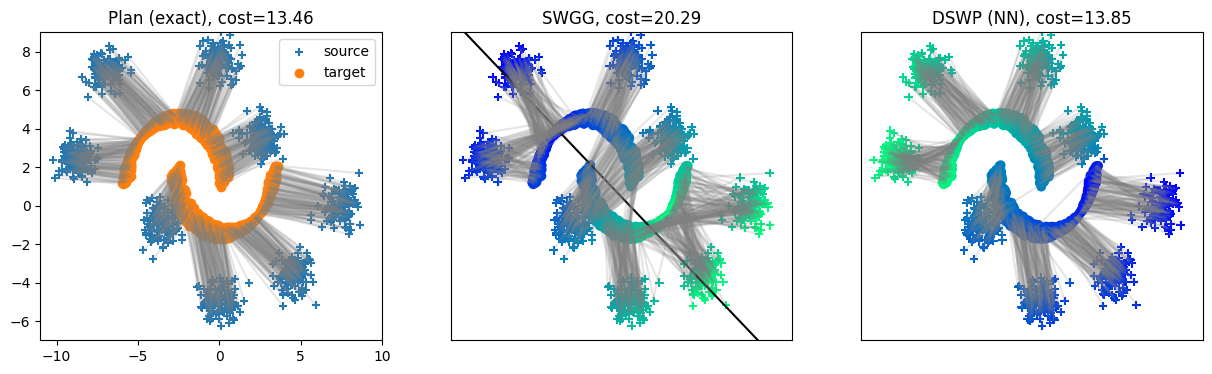

In [23]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.scatter(x0[:,0].detach().numpy(), x0[:,1].detach().numpy(), c= "C0", label='source', marker="+")
plt.scatter(x1[:,0].detach().numpy(), x1[:,1].detach().numpy(), c = 'C1', label='target')
ot.plot.plot2D_samples_mat(x0.detach().numpy(), x1.detach().numpy(), plan, linestyle="solid", alpha=.2,c="grey")
plt.legend()

plt.xlim(-11, 10)
plt.ylim(-7, 9)

plt.title(f"Plan (exact), cost={cost:.2f}")
col1 = np.arange(1,x0_plot_lin.shape[0]+1)/x0_plot_lin.shape[0]

plt.subplot(132)
plt.scatter(x0_plot_lin[:, 0], x0_plot_lin[:, 1], c=col1, cmap="winter", marker="+")
plt.scatter(x1_plot_lin[:, 0], x1_plot_lin[:, 1], c=col1, cmap="winter")
plt.xticks([])
plt.yticks([])
plt.xlim(-11, 10)
plt.ylim(-7, 9)

plt.axline(torch.tensor([0,0]), model_lin.weight[0].detach(), color='k')

for x0i, x1i in zip(x0_plot_lin, x1_plot_lin):
    plt.plot([x0i[0], x1i[0]],
             [x0i[1], x1i[1]],
            linestyle="solid", alpha=.2,c="grey")
plt.title(f"SWGG, cost={cost_lin:.2f}")

plt.subplot(133)

plt.scatter(x0_plot_nn[:, 0], x0_plot_nn[:, 1], c=col1, cmap="winter", marker="+")
plt.scatter(x1_plot_nn[:, 0], x1_plot_nn[:, 1], c=col1, cmap="winter")
plt.xlim(-11, 10)
plt.ylim(-7, 9)
plt.xticks([])
plt.yticks([])
for x0i, x1i, col in zip(x0_plot_nn, x1_plot_nn, col1):
    plt.plot([x0i[0], x1i[0]],
             [x0i[1], x1i[1]],
            linestyle="solid", alpha=.2,c="grey")
plt.title(f"DSWP (NN), cost={cost_nn:.2f}")
plt.show()

In [ ]:
#save the results on a dictionnary
res = {}
res["x0"] = x0.detach().numpy()
res["x1"] = x1.detach().numpy()
res["cost"] = cost
res["plan"] = plan
res["x0_plot_lin"] = x0_plot_lin
res["x1_plot_lin"] = x1_plot_lin
res["model_lin"] = model_lin
res['cost_lin'] = cost_lin
res['x0_plot_nn'] = x0_plot_nn
res['x1_plot_nn'] = x1_plot_nn
res['cost_nn'] = cost_nn

import pickle 
with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(res, f)